## Packages

In [1]:
# Cleaning
import pandas as pd, numpy as np, seaborn as sns
import glob
import datetime
import matplotlib.pyplot as plt
import math
from scipy import stats

#Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import mutual_info_classif

#Models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Metrics
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix


## Input all files

In [116]:
path = r'./player_stats_table' # use your path
files_path = glob.glob(path + "/*.csv")

mutiple_files = [pd.read_csv(file, index_col = None) for file in files_path]
df = pd.concat(mutiple_files, axis  = 0, ignore_index=True)
df.drop(df.columns[0], axis = 1, inplace = True)
print(df.shape)
df.head(5)

(323024, 39)


,Date,Game_Index,Home_Away,Team,Players,MP,FG,FGA,FG%,3P,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
0,2018-10-16,1,Home,BOS,Al Horford,29:57,4.0,7.0,0.571,0.0,...,0.0,13.1,6.3,9.0,0.0,10.5,28.7,14.3,90.0,80.0
1,2018-10-16,1,Home,BOS,Kyrie Irving,29:00,2.0,14.0,0.143,1.0,...,0.0,13.5,6.5,29.9,0.0,0.0,16.8,25.3,63.0,89.0
2,2018-10-16,1,Home,BOS,Jayson Tatum,28:56,9.0,17.0,0.529,1.0,...,6.3,23.7,14.6,18.4,1.6,0.0,5.0,28.6,125.0,83.0
3,2018-10-16,1,Home,BOS,Jaylen Brown,28:23,5.0,13.0,0.385,1.0,...,9.6,6.9,8.3,10.1,0.0,0.0,12.6,22.9,91.0,89.0
4,2018-10-16,1,Home,BOS,Gordon Hayward,24:37,4.0,12.0,0.333,1.0,...,7.4,11.9,9.6,0.0,7.5,0.0,0.0,21.4,90.0,74.0


### Delete Playoff Game

In [117]:
# Regular Season or not
def getRegularSeason(table, date_col):
    regularseason = []
    for gameday in table[date_col]:
        d = datetime.date(int(gameday.split("-")[0]),
                          int(gameday.split("-")[1]),
                          int(gameday.split("-")[2]))
        if datetime.date(2006,10,31) <= d <= datetime.date(2007,4,18):
            regularseason.append(1)
        elif datetime.date(2007,10,30) <= d <= datetime.date(2008,4,16):
            regularseason.append(1)
        elif datetime.date(2008,10,28) <= d <= datetime.date(2009,4,16):
            regularseason.append(1)
        elif datetime.date(2009,10,27) <= d <= datetime.date(2010,4,14):
            regularseason.append(1)
        elif datetime.date(2010,10,26) <= d <= datetime.date(2011,4,13):
            regularseason.append(1)
        elif datetime.date(2011,12,25) <= d <= datetime.date(2012,4,26):
            regularseason.append(1)        
        elif datetime.date(2012,10,30) <= d <= datetime.date(2013,4,17):
            regularseason.append(1)    
        elif datetime.date(2013,10,29) <= d <= datetime.date(2014,4,16):
            regularseason.append(1)  
        elif datetime.date(2014,10,28) <= d <= datetime.date(2015,4,15):
            regularseason.append(1)
        elif datetime.date(2015,10,27) <= d <= datetime.date(2016,4,13):
            regularseason.append(1)   
        elif datetime.date(2016,10,25) <= d <= datetime.date(2017,4,12):
            regularseason.append(1)
        elif datetime.date(2017,10,17) <= d <= datetime.date(2018,4,11):
            regularseason.append(1)
        elif datetime.date(2018,10,16) <= d <= datetime.date(2019,4,10):
            regularseason.append(1)
        else:
            regularseason.append(0)
            
    return regularseason


In [118]:
df = df[np.array(getRegularSeason(df, "Date")) == 1]

In [119]:
df.shape

(302018, 39)

### Teams Played by Date

> The following information is used to scrape line-up data.

In [120]:
team_played_date = df.loc[:, ["Date", "Game_Index", "Team"]].drop_duplicates()
team_played_date.reset_index(drop = True, inplace = True)
date_str = team_played_date["Date"].map(str)

def getGameYear(date_col):
    gameYear = []
    for day in date_str:
        if int(day.split("-")[1]) >= 9:
            gameYear.append(day.split("-")[0][-2:])
        else:
            gameYear.append(str(int(day.split("-")[0][-2:]) - 1))
    return gameYear

team_played_date["GameYear"] = getGameYear(date_str)

In [121]:
#team_played_date.to_csv("Team_Played_Date.csv", index = False)

## Cleaning

### Descriptive Statistics: Player Level

In [221]:
df.describe()

,Game_Index,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
count,302018.000000,302018.000000,302018.000000,287528.000000,302018.000000,302018.000000,187767.000000,302018.000000,302018.000000,175783.000000,...,301968.000000,301968.000000,301968.000000,301964.000000,301968.000000,301968.000000,292134.000000,301968.000000,301968.000000,301971.000000
mean,4.942239,3.657140,8.020188,0.440953,0.765838,2.143515,0.325056,1.712332,2.252101,0.747852,...,5.152501,14.729911,9.972409,13.244961,1.547255,1.617464,13.454026,19.106303,101.485515,108.277288
std,3.036210,3.015706,5.605381,0.235302,1.201762,2.491394,0.309696,2.321787,2.841572,0.286961,...,7.793889,12.133294,7.996619,15.421724,2.523073,3.441084,15.385453,8.906044,45.970141,14.349637
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1000.000000
25%,2.000000,1.000000,4.000000,0.313000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,6.300000,4.500000,0.000000,0.000000,0.000000,0.000000,13.500000,78.000000,100.000000
50%,4.000000,3.000000,7.000000,0.444000,0.000000,1.000000,0.333000,1.000000,2.000000,0.818000,...,2.800000,12.900000,8.600000,9.800000,0.000000,0.000000,10.700000,18.800000,104.000000,109.000000
75%,7.000000,5.000000,11.000000,0.571000,1.000000,4.000000,0.500000,3.000000,4.000000,1.000000,...,7.800000,21.000000,14.000000,20.100000,2.500000,2.400000,20.000000,24.300000,127.000000,117.000000
max,15.000000,24.000000,50.000000,1.000000,14.000000,24.000000,1.000000,25.000000,39.000000,1.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,300.000000,162.000000


### Abnormal Record

> The minimal number of "AST%" and "DRtg" should not be -1000. That does not make sense at all!!!! <br><br>However, there are only 10 player having this situation during 2007 and 2018, and most importantly, they played very few minutes. That means they barely have any infuence to the team at all. I decided to take the value as NA. In the further step, they will be considered 0 when transforming the table to the team-based level.<br><br> Let's take a look at the meaning of "DRtg": Defensive Rating estimates how many points the player allowed per 100 possessions he individually faced while on the court. It seems unreasonable if the value is negative. Similarly, those who have negative value on "DRtg" barely played on the court. I will also change the negative number to NA.

In [122]:
df.loc[(df["AST%"] == -1000) | (df["DRtg"] == -1000), ["AST", "AST%", "DRtg"]]

,AST,AST%,DRtg
16875,1.0,-1000.0,117.0
28951,0.0,0.0,-1000.0
149545,1.0,-1000.0,125.0
180327,0.0,0.0,-1000.0
218723,1.0,-1000.0,96.0
218724,1.0,-1000.0,-4.0
240622,1.0,-1000.0,117.0
318218,1.0,-1000.0,124.0
318866,1.0,-1000.0,120.0


In [123]:
#df[(df["Date"] == "2019-02-08") & (df["Team"] == "MIL")].loc[:, ['Players', 'MP', 'FG', 'AST', 'AST%']]

In [196]:
df[df["DRtg"] < 0]

,Date,Game_Index,Home_Away,Team,Players,MP,FG,FGA,FG%,3P,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
2860,2018-11-03,8,Home,SAS,Quincy Pondexter,0.900000,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,53.2,0.0,NaN,0.0,0.0,-9.0
21977,2019-03-19,3,Home,LAC,Sindarius Thornwell,0.500000,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,94.4,0.0,NaN,0.0,0.0,-84.0
24662,2019-04-05,9,Home,OKC,Deonte Burton,0.750000,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,62.4,0.0,NaN,0.0,0.0,-30.0
30035,2009-11-10,4,Home,MEM,Steven Hunter,1.066667,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,53.0,0.0,0.0,44.0,0.0,-1.0
33192,2009-12-02,3,Home,CLE,Darnell Jackson,0.816667,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,1.0,63.7,0.0,NaN,0.0,0.0,-36.0
36079,2009-12-22,2,Home,CHA,Acie Law,0.916667,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,1.0,57.7,74.8,0.0,47.3,244.0,-73.0
40955,2010-01-24,3,Away,LAC,DeAndre Jordan,0.283333,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,NaN,0.0,0.0,-292.0
45614,2010-02-28,4,Away,WAS,Mike Harris,0.466667,0.0,0.0,NaN,0.0,...,0.0,100.0,100.0,0.0,0.0,0.0,NaN,0.0,0.0,-9.0
45789,2010-03-01,5,Home,LAC,Brian Skinner,0.383333,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,NaN,0.0,0.0,-153.0
48405,2010-03-19,2,Home,CHI,Joe Alexander,0.400000,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,NaN,0.0,0.0,-177.0


#### AST%: -1000 to NA

In [230]:
df["AST%"] = [None if i == -1000 else i for i in df["AST"]]

#### DRtg: negative value to NA

In [231]:
df["DRtg"] = [None if i < 0 else i for i in df["DRtg"]]

### Is there NA value in the raw dataset?

In [124]:
# Missing Value
col_has_missing = df.isnull().apply(sum, axis = 0) > 0
missing_value = pd.DataFrame(df.isnull().apply(sum, axis = 0)[col_has_missing]).transpose()
missing_value

,FG%,3P%,FT%,+/-,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
0,14490,114251,126235,29,12558,14490,14490,14490,50,50,50,54,50,50,9884,50,50,47


### Why is there a missing data?

> By checking out the number of missing data in each column, it seems there are some patterns among several columns. I guess the data is missing by certain reasons. So, let's get a closer look.


> **Conclusion 1:** <br> 1. Players who did not play the game would not have a record. <br><br> 2. Taking TOV% as an example, the reason why TOV% is missing is resulted by the zero number of TOV. <br><br> 3. Plus-Minus a.k.a. +/-, simply keeps track of the net changes in score when a given player is either on or off the court. It looks like when a player only plays less than one minute, it would be NA. However, since the player did not have much contribution, I will just take it as a zero. <br><br> **Conclusion 2:** <br> When counting the weighted average, I will ignore the NA value.

#### All Missing Features?

In [29]:
#sum(df.isnull().apply(sum, axis = 1) == len(missing_value.columns)) #19
df[df.isnull().apply(sum, axis = 1) == len(missing_value.columns)].head(5)

,Date,Game_Index,Home_Away,Team,Players,MP,FG,FGA,FG%,3P,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
5789,2018-11-23,5,Home,DET,José Calderón,0:00,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80234,2009-05-11,2,Away,DEN,Renaldo Balkman,0:00,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85899,2012-12-02,1,Away,ORL,Gustavo Ayón,0:00,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115996,2007-12-20,2,Home,DEN,Bobby Jones,0:00,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140366,2013-12-02,3,Away,ATL,Pero Antić,0:00,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### "MP" more than 0:00

In [125]:
# MP: from string to int
df["MP"] = df["MP"].map(lambda x: (int(x.split(":")[0]) * 60 + int(x.split(":")[1])) / 60)

df_played = df[df["MP"] > 0]
col_played_missing = df_played.isnull().apply(sum, axis = 0) > 0
played_missing_value = pd.DataFrame(df_played.isnull().apply(sum, axis = 0)[col_played_missing]).transpose()
played_missing_value

,FG%,3P%,FT%,+/-,TS%,eFG%,3PAr,FTr,AST%,TOV%
0,14440,114201,126188,11,12511,14440,14440,14440,4,9837


#### Percentage %

Including FG%, 3P%, FT%, TS%, eFG%, AST%, TOV%

In [126]:
percentage_missing = played_missing_value.drop(["+/-"], axis = 1).columns
df_played[df_played.loc[:, list(percentage_missing)].isnull().apply(sum, axis = 1) > 0].head(5)

,Date,Game_Index,Home_Away,Team,Players,MP,FG,FGA,FG%,3P,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
5,2018-10-16,1,Home,BOS,Terry Rozier,26.516667,5.0,10.0,0.500,1.0,...,0.0,29.6,14.2,5.5,0.0,3.0,9.1,17.0,102.0,84.0
7,2018-10-16,1,Home,BOS,Marcus Morris,20.500000,7.0,12.0,0.583,2.0,...,8.8,38.2,23.0,0.0,4.5,0.0,7.7,26.0,122.0,74.0
8,2018-10-16,1,Home,BOS,Aron Baynes,19.233333,3.0,7.0,0.429,2.0,...,14.1,5.1,9.8,21.7,0.0,0.0,12.5,17.0,124.0,89.0
9,2018-10-16,1,Home,BOS,Daniel Theis,4.133333,0.0,0.0,NaN,0.0,...,0.0,23.7,11.4,0.0,0.0,0.0,NaN,0.0,0.0,86.0
10,2018-10-16,1,Home,BOS,Semi Ojeleye,1.450000,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,91.0


#### +/-

In [9]:
# plus and minus is missing
df_played[df_played["+/-"].isnull()].iloc[:10, :30]

,Date,Game_Index,Home_Away,Team,Players,MP,FG,FGA,FG%,3P,...,BLK,TOV,PF,PTS,+/-,TS%,eFG%,3PAr,FTr,ORB%
207,2018-10-17,8,Home,PHO,Mikal Bridges,0.183333,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
1820,2018-10-28,2,Home,DAL,Ryan Broekhoff,0.350000,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
21642,2019-03-17,4,Home,MIA,Duncan Robinson,0.183333,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
65917,2009-01-14,8,Home,OKC,Chucky Atkins,0.833333,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
141148,2013-12-07,7,Away,DAL,Wayne Ellington,0.283333,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
159622,2014-04-11,10,Away,WAS,Garrett Temple,0.016667,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
160976,2014-04-25,3,Home,WAS,Al Harrington,0.116667,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
162304,2014-05-31,1,Home,OKC,Thabo Sefolosha,0.083333,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
196107,2011-01-09,7,Away,SAC,Darnell Jackson,0.016667,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
214174,2014-11-12,8,Away,BRK,Cory Jefferson,0.100000,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0


In [10]:
df_played[df_played["+/-"].isnull()]["MP"]

207       0.183333
1820      0.350000
21642     0.183333
65917     0.833333
141148    0.283333
159622    0.016667
160976    0.116667
162304    0.083333
196107    0.016667
214174    0.100000
227183    0.733333
227194    0.733333
319714    0.050000
321937    0.200000
Name: MP, dtype: float64

In [11]:
# plus and minus is zero
df_played[df_played["+/-"] == 0].iloc[:10, :30]

,Date,Game_Index,Home_Away,Team,Players,MP,FG,FGA,FG%,3P,...,BLK,TOV,PF,PTS,+/-,TS%,eFG%,3PAr,FTr,ORB%
34,2018-10-16,2,Home,GSW,Jonas Jerebko,6.166667,0.0,0.0,NaN,0.0,...,0.0,1.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
39,2018-10-16,2,Away,OKC,Terrance Ferguson,26.516667,0.0,2.0,0.000,0.0,...,0.0,1.0,3.0,0.0,0.0,0.000,0.000,1.000,0.000,6.4
74,2018-10-17,2,Home,DET,Glenn Robinson,20.066667,2.0,3.0,0.667,0.0,...,1.0,1.0,0.0,4.0,0.0,0.667,0.667,0.333,0.000,0.0
76,2018-10-17,2,Home,DET,Zach Lofton,3.750000,0.0,1.0,0.000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.000,0.000,1.000,0.000,0.0
121,2018-10-17,4,Home,IND,T.J. Leaf,0.966667,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
138,2018-10-17,5,Home,LAC,Shai Gilgeous-Alexander,28.200000,5.0,6.0,0.833,0.0,...,1.0,3.0,1.0,11.0,0.0,0.854,0.833,0.000,0.167,0.0
152,2018-10-17,5,Away,DEN,Mason Plumlee,13.366667,1.0,3.0,0.333,0.0,...,3.0,1.0,5.0,2.0,0.0,0.258,0.333,0.000,0.667,6.9
168,2018-10-17,6,Away,ATL,Kent Bazemore,30.266667,6.0,12.0,0.500,2.0,...,1.0,2.0,3.0,14.0,0.0,0.583,0.583,0.500,0.000,7.4
215,2018-10-17,8,Away,DAL,Dwight Powell,17.483333,6.0,8.0,0.750,0.0,...,1.0,0.0,1.0,16.0,0.0,0.752,0.750,0.125,0.750,11.4
250,2018-10-17,10,Away,MIN,Andrew Wiggins,37.450000,8.0,18.0,0.444,2.0,...,0.0,2.0,3.0,20.0,0.0,0.530,0.500,0.333,0.111,0.0


In [128]:
#df_played.to_csv("df_play_07_18.csv", index = False)

## Win or Loss

> Extracting the outcome of the game and returning 1 as the home team won

In [129]:
def SumPoints(group):
    return group["PTS"].sum()

# do group by
df_drop = df.drop(["Players", "MP"], axis = 1)
df_drop_grouped = df_drop.groupby(["Date", "Game_Index", "Team", "Home_Away"])
# Get the score
table_grouped = df_drop_grouped.apply(SumPoints)
win_loss_df = pd.DataFrame(table_grouped, columns = ["HomeWin"]).reset_index()

# count win or loss as 1 and 0
win_loss_df_sorted = win_loss_df.sort_values(by = ["Date", "Game_Index", "Home_Away"])
win_loss_df_sorted = win_loss_df_sorted.groupby(["Date", "Game_Index"]).apply(lambda x: int(x.iloc[0, 4] < x.iloc[1, 4]))
win_loss_df_sorted = pd.DataFrame(win_loss_df_sorted, columns = ["HomeWin"]).reset_index()

In [130]:
win_loss_df_sorted.head(5)

,Date,Game_Index,HomeWin
0,2007-10-30,1,0
1,2007-10-30,2,0
2,2007-10-30,3,1
3,2007-10-31,1,0
4,2007-10-31,2,1


In [131]:
#win_loss_df_sorted.to_csv("win_loss_df_sorted.csv", index = False)

## Get the Right Format of the Table

### Team Weighted Transformation

> Implement weighted average transformation from the player-level data to the team-level data

In [236]:
def team_table_transformed(table):
    df_drop = table.drop(["Players"], axis = 1)
    df_drop_grouped = df_drop.groupby(["Date", "Game_Index", "Team", "Home_Away"])

    def weightedavg(group, col):
        d = group[col]
        w = 1/group["MP"]
        return (d * w).sum() / w.sum() #will ignore missing value

    table_transformed = []
    for col in list(df_drop.columns[5:]):
        table_transformed.append(df_drop_grouped.apply(lambda x: weightedavg(x, col)))
    new_df = pd.concat(table_transformed, axis = 1)
    new_df.columns = list(df_drop.columns[5:])
    
    return new_df

In [238]:
new_df = team_table_transformed(df_played).reset_index()

In [239]:
new_df.shape

(29038, 37)

### Save the Weighted Average Table

> Because it takes so long to compute

In [240]:
#new_df.to_csv("weighted_average_table/weighted_average_team.csv", index = False)

In [2]:
new_df = pd.read_csv("weighted_average_table/weighted_average_team.csv")
new_df.head()

,Date,Game_Index,Team,Home_Away,FG,FGA,FG%,3P,3PA,3P%,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
0,2007-10-30,1,GSW,Home,1.780134,4.374039,0.475584,0.400936,1.441922,0.114869,...,1.955111,23.326176,12.516002,1.162786,0.438423,1.011197,11.250545,14.368938,106.729801,110.600796
1,2007-10-30,1,UTA,Away,0.893303,2.336594,0.072664,0.131325,0.352637,0.032831,...,2.701548,5.414539,4.074880,0.587101,0.987300,0.285720,10.329118,8.529709,31.391157,96.531926
2,2007-10-30,2,HOU,Away,1.596271,3.873605,0.187242,0.312319,1.270269,0.059699,...,2.823215,11.858122,7.873656,1.887982,1.271963,0.574826,23.293880,11.420159,107.132786,101.828721
3,2007-10-30,2,LAL,Home,0.491358,1.320536,0.074908,0.024221,0.116684,0.008065,...,2.252566,2.443185,2.334581,0.338693,0.834037,0.205968,3.190883,4.293657,19.295991,113.061655
4,2007-10-30,3,POR,Away,2.255435,4.748426,0.525612,0.269105,0.811432,0.113401,...,7.311202,14.809516,11.445579,0.770582,0.062946,0.364746,26.020764,19.675757,81.534388,116.661000


In [242]:
new_df.shape

(29038, 37)

### Add Team ID

> Because some teams used to change the location and the team name, using the team id instead of team name will help me to move the feature information from the t period to the t-1 period

In [3]:
# Team ID
id_dict = {}
with open("Team_id.txt", "r") as file:
    for line in file:
        id_dict[line.split("|")[0]] = line.split("|")[1].strip("\n")

new_df.insert(3, "Team_id", [id_dict[tm] for tm in new_df["Team"]])
#new_df["Team_id"] = [id_dict[tm] for tm in new_df["Team"]]

In [4]:
new_df.head()

,Date,Game_Index,Team,Team_id,Home_Away,FG,FGA,FG%,3P,3PA,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
0,2007-10-30,1,GSW,1610612744,Home,1.780134,4.374039,0.475584,0.400936,1.441922,...,1.955111,23.326176,12.516002,1.162786,0.438423,1.011197,11.250545,14.368938,106.729801,110.600796
1,2007-10-30,1,UTA,1610612762,Away,0.893303,2.336594,0.072664,0.131325,0.352637,...,2.701548,5.414539,4.074880,0.587101,0.987300,0.285720,10.329118,8.529709,31.391157,96.531926
2,2007-10-30,2,HOU,1610612745,Away,1.596271,3.873605,0.187242,0.312319,1.270269,...,2.823215,11.858122,7.873656,1.887982,1.271963,0.574826,23.293880,11.420159,107.132786,101.828721
3,2007-10-30,2,LAL,1610612747,Home,0.491358,1.320536,0.074908,0.024221,0.116684,...,2.252566,2.443185,2.334581,0.338693,0.834037,0.205968,3.190883,4.293657,19.295991,113.061655
4,2007-10-30,3,POR,1610612757,Away,2.255435,4.748426,0.525612,0.269105,0.811432,...,7.311202,14.809516,11.445579,0.770582,0.062946,0.364746,26.020764,19.675757,81.534388,116.661000


### Difference between two team

In [5]:
delta_df = new_df.copy()

In [6]:
for col in new_df.columns[5:]:
    home_away = new_df.groupby(['Date', 'Game_Index'])[col].diff(periods = -1)
    away_home = new_df.groupby(['Date', 'Game_Index'])[col].diff()
    col_list = []
    for i in range(len(new_df)):
        if np.isnan(home_away[i]): #away-home
            col_list.append(away_home[i])
        elif np.isnan(away_home[i]): #home-away
            col_list.append(home_away[i])
    delta_df[col] = col_list

KeyboardInterrupt: 

In [247]:
#delta_df.to_csv("weighted_average_table/delta_df_07_18.csv", index = False)

In [7]:
delta_df = pd.read_csv("weighted_average_table/delta_df_07_18.csv")

In [8]:
delta_df.shape

(29038, 38)

In [9]:
delta_df.head(2)

,Date,Game_Index,Team,Team_id,Home_Away,FG,FGA,FG%,3P,3PA,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
0,2007-10-30,1,GSW,1610612744,Home,0.886831,2.037445,0.402919,0.269611,1.089285,...,-0.746437,17.911638,8.441122,0.575685,-0.548877,0.725477,0.921427,5.83923,75.338644,14.06887
1,2007-10-30,1,UTA,1610612762,Away,-0.886831,-2.037445,-0.402919,-0.269611,-1.089285,...,0.746437,-17.911638,-8.441122,-0.575685,0.548877,-0.725477,-0.921427,-5.83923,-75.338644,-14.06887


### Rolling Average 5 games

In [94]:
unique_team_id = list(set(delta_df["Team_id"]))
table_rolling_mean = []
for teamid in unique_team_id:
    delta_sorted = delta_df[delta_df["Team_id"] == teamid].sort_values(by = "Date", ascending = True)
    # count the rolling mean
    right_rolling = delta_sorted.iloc[:, 5:].rolling(window = 5, min_periods = 1).mean().reset_index(drop = True)
    # move t-1 to t 
    #home_rolling.reset_index(drop = True, inplace = True)
    #right_rolling = home_rolling.iloc[:-1, :].reset_index(drop = True)
    # combind
    left_rolling = delta_sorted.iloc[:, :5].reset_index(drop = True)
    rolling_df = pd.concat([left_rolling, right_rolling], axis = 1)
    table_rolling_mean.append(rolling_df)

In [91]:

delta_sorted = delta_df[delta_df["Team_id"] == 1610612737].sort_values(by = "Date", ascending = True)
# count the rolling mean
right_rolling = delta_sorted.iloc[:, 5:].rolling(window = 5, min_periods = 1).mean().reset_index(drop = True)
left_rolling = delta_sorted.iloc[:, :5].reset_index(drop = True)


In [97]:
# New Dataframe
new_rolling_df = pd.concat(table_rolling_mean, axis = 0)
new_rolling_df.head()

,Date,Game_Index,Team,Team_id,Home_Away,FG,FGA,FG%,3P,3PA,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
0,2007-11-02,1,ATL,1610612737,Home,-2.383543,-4.835196,-0.308977,-0.136268,-1.243700,...,-0.218748,-11.357255,-5.781903,-0.434684,-0.189396,-1.180640,-15.039614,-20.828050,-56.420350,-3.254261
1,2007-11-04,2,ATL,1610612737,Away,-0.333966,-0.913943,-0.013835,0.057446,-0.437546,...,1.220154,1.064321,1.402923,0.027107,0.197007,-0.350647,-15.652335,-11.600778,4.194219,-4.857733
2,2007-11-06,8,ATL,1610612737,Away,-1.003753,-2.413009,-0.145939,-0.064672,-0.642012,...,-0.506457,-6.228269,-3.268159,-0.617053,-0.220849,-1.054821,-17.973363,-14.235488,-24.736948,3.208953
3,2007-11-07,1,ATL,1610612737,Home,-0.687720,-1.896858,-0.087310,-0.082673,-0.614208,...,4.927276,-3.329020,0.861231,-0.474867,-0.085773,-0.639369,-13.160192,-12.094712,10.366280,0.833180
4,2007-11-09,1,ATL,1610612737,Away,-0.658542,-1.629290,-0.123079,-0.062968,-0.441089,...,-0.964754,-0.871769,-0.880904,-0.474474,-0.047583,1.840414,-4.855447,-15.630545,-10.253713,3.711096


### Getting all features at t-1 period

> For every team, I shifted their features back to the the last game. So, the first game in 2007 is removed. Then, I also marked the feature name with "_1" <br><br> NOTE: each team's first game in 2007 will be removed

In [98]:
unique_team_id = list(set(delta_df["Team_id"]))
table_t_1 = []
for teamid in unique_team_id:
    one_team_df = new_rolling_df[new_rolling_df["Team_id"] == teamid].sort_values(by = "Date", ascending = False)
    # without the first row of features
    right = one_team_df.iloc[1:, 5:].reset_index(drop = True)
    # without the last row of game information
    left = one_team_df.iloc[:-1, :5].reset_index(drop = True)
    # merge left and right
    merge_table = pd.concat([left, right], axis = 1)
    table_t_1.append(merge_table)

In [99]:
# New Dataframe
df_t1 = pd.concat(table_t_1, axis = 0)

In [107]:
print(df_t1.shape)
df_t1.tail()

(29008, 38)


,Date,Game_Index,Team,Team_id,Home_Away,FG,FGA,FG%,3P,3PA,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
962,2007-11-11,2,CHA,1610612766,Home,-0.812432,-1.008602,-0.053467,-0.139121,-0.261402,...,9.806490,-13.070912,-10.450797,-0.434369,-1.195692,-1.005404,8.592994,4.663093,2.452217,33.412120
963,2007-11-09,2,CHA,1610612766,Home,-0.726536,-0.687508,-0.054606,-0.107482,-0.089835,...,11.899734,-20.931769,-15.732980,-0.450194,-1.403553,-0.618398,10.559348,2.652055,9.797085,44.317211
964,2007-11-07,4,CHA,1610612766,Away,-0.504794,-0.486313,-0.059596,-0.009027,-0.086098,...,15.601569,-29.797180,-21.961031,-0.396338,-0.588829,-0.388858,12.189452,4.198772,22.791123,47.691522
965,2007-11-06,1,CHA,1610612766,Home,-0.405790,-0.710168,-0.001978,0.085742,-0.077131,...,23.793935,-46.837152,-34.005513,-0.218789,0.198395,-0.557247,1.067519,8.075993,57.040177,53.293386
966,2007-11-04,5,CHA,1610612766,Away,0.953618,2.698075,0.161723,0.119950,0.457209,...,46.132573,-91.650693,-68.459173,0.414290,1.197444,0.422580,2.894549,23.680041,77.495174,105.839743


### Create Home and Away features.

> To do so, I will separate the table into a home team table and a away team table. Then, I will concatenate the two tables by the date and the game index.

In [108]:
home_table = df_t1[df_t1["Home_Away"] == "Home"]
away_table = df_t1[df_t1["Home_Away"] == "Away"]

In [112]:
print(away_table.shape)
print(home_table.shape)

(14506, 38)
(14502, 38)


In [113]:
merge_df_t1 = home_table.merge(away_table, on = ["Date", "Game_Index"], suffixes = ("_h", "_a")) # inner

In [ ]:
# Use the following scripts, if I want to add _1 befind every feature name
#new_col = list(new_df.columns[:5]) + [i+"_1" for i in new_df.columns[5:]]
#df_t1.columns = new_col

In [114]:
print(merge_df_t1.shape)
merge_df_t1.head()

(14500, 74)


,Date,Game_Index,Team_h,Team_id_h,Home_Away_h,FG_h,FGA_h,FG%_h,3P_h,3PA_h,...,ORB%_a,DRB%_a,TRB%_a,AST%_a,STL%_a,BLK%_a,TOV%_a,USG%_a,ORtg_a,DRtg_a
0,2019-04-10,1,ATL,1610612737,Home,0.394808,1.320976,-0.018244,0.280853,0.758870,...,-0.724149,-1.067893,-0.475731,-0.421560,0.804500,2.164576,-2.995101,0.875726,-6.070306,-1.264972
1,2019-04-03,1,ATL,1610612737,Home,0.379044,1.050788,0.038525,0.190366,0.918754,...,0.143074,-1.418240,-0.527659,-0.218568,-0.163201,-0.306321,3.248123,0.997849,-15.874402,4.879411
2,2019-03-31,1,ATL,1610612737,Home,-0.119057,-0.253018,0.021952,0.096790,0.233080,...,5.608696,1.074446,4.229275,0.251184,-1.795773,0.202466,2.533234,3.577925,-22.592667,-10.173305
3,2019-03-29,1,ATL,1610612737,Home,-0.335127,-1.074058,0.013910,-0.040536,-0.288975,...,1.163193,-2.297644,-0.182612,-0.514062,-1.379662,0.309312,3.078486,8.560558,32.163882,-5.898624
4,2019-03-23,1,ATL,1610612737,Home,0.175189,-0.071893,0.062703,0.045945,-0.362332,...,2.238182,4.388547,3.843189,0.426458,0.110475,0.452454,5.635265,2.248212,-2.635005,-6.403638


### Add the game outcome column

> I have compute the outcome in the section 3.

In [132]:
final_df_t1 = win_loss_df_sorted.merge(merge_df_t1, how = "right", on = ["Date", "Game_Index"])
final_df_t1.drop(["Home_Away_h", "Home_Away_a"], axis = 1, inplace = True)
final_df_t1.head()

,Date,Game_Index,HomeWin,Team_h,Team_id_h,FG_h,FGA_h,FG%_h,3P_h,3PA_h,...,ORB%_a,DRB%_a,TRB%_a,AST%_a,STL%_a,BLK%_a,TOV%_a,USG%_a,ORtg_a,DRtg_a
0,2007-11-01,3,0,UTA,1610612762,-0.886831,-2.037445,-0.402919,-0.269611,-1.089285,...,0.570649,9.414937,5.539075,1.549289,0.437926,0.368859,20.102997,7.126502,87.836795,-11.232933
1,2007-11-02,4,0,CHI,1610612741,1.506532,3.968128,0.053959,0.233271,0.968204,...,-5.606685,15.017301,4.629001,0.071762,-0.202164,0.981680,-12.059018,-13.687131,-18.432661,5.213228
2,2007-11-02,6,1,IND,1610612754,0.986989,2.419909,0.027563,0.483785,1.205410,...,-4.844936,-13.814899,-8.657476,-1.511524,-2.371511,-1.052885,-7.411891,-14.669138,-90.112650,20.350179
3,2007-11-02,9,0,NJN,1610612751,-1.506532,-3.968128,-0.053959,-0.233271,-0.968204,...,5.606685,-15.017301,-4.629001,-0.071762,0.202164,-0.981680,12.059018,13.687131,18.432661,-5.213228
4,2007-11-02,10,1,NOH,1610612740,0.492089,0.478764,0.028861,0.532684,0.935760,...,5.612069,9.498093,8.127017,0.129500,-0.567880,0.007774,21.988696,13.020139,42.419868,5.395722


### Save the Cleaned Table Again

In [264]:
#final_df_t1.to_csv("weighted_average_table/cleaned_team_table.csv", index = False)

In [134]:
#final_df_t1.to_csv("weighted_average_table/five_games_average_team.csv", index = False)

## Combine the Other Datasets

### Read the Cleaned Table

We only need the data from 2008 season to 2018 season.

In [139]:
final_df_t1 = pd.read_csv("weighted_average_table/five_games_average_team.csv")

#### Check the amount of games each season

In [136]:
def getGameYear(table):
	date_col = table["Date"]
	gameYear = []
	for day in date_col:
		if int(day.split("-")[1]) >= 9:
			gameYear.append(day.split("-")[0][-2:])
		else:
			if int(day.split("-")[0]) <= 2010:
				gameYear.append('0' + str(int(day.split("-")[0][-2:]) - 1))
			else:
				gameYear.append(str(int(day.split("-")[0][-2:]) - 1))
	table["Season"] = gameYear
	return table
getGameYear(final_df_t1).groupby("Season").count()

,Date,Game_Index,HomeWin,Team_h,Team_id_h,FG_h,FGA_h,FG%_h,3P_h,3PA_h,...,ORB%_a,DRB%_a,TRB%_a,AST%_a,STL%_a,BLK%_a,TOV%_a,USG%_a,ORtg_a,DRtg_a
Season,,,,,,,,,,,,,,,,,,,,,
07,1211,1211,1211,1211,1211,1211,1211,1211,1211,1211,...,1211,1211,1211,1211,1211,1211,1211,1211,1211,1211
08,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,...,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230
09,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,...,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230
10,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,...,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230
11,990,990,990,990,990,990,990,990,990,990,...,990,990,990,990,990,990,990,990,990,990
12,1229,1229,1229,1229,1229,1229,1229,1229,1229,1229,...,1229,1229,1229,1229,1229,1229,1229,1229,1229,1229
13,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,...,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230
14,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,...,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230
15,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,...,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230


In [137]:
final_df_t1.drop("Season", axis = 1, inplace = True)

#### Filter Data (2008 - 2018)

In [140]:
final_df_t1["Date"] = final_df_t1["Date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
final_df_t1 = final_df_t1[final_df_t1["Date"] > datetime.datetime(2008, 9, 1)]
print(final_df_t1.shape)
final_df_t1.head()

(13289, 73)


,Date,Game_Index,HomeWin,Team_h,Team_id_h,FG_h,FGA_h,FG%_h,3P_h,3PA_h,...,ORB%_a,DRB%_a,TRB%_a,AST%_a,STL%_a,BLK%_a,TOV%_a,USG%_a,ORtg_a,DRtg_a
1211,2008-10-28,1,1,BOS,1610612738,-0.325629,-0.946490,-0.058638,-0.058517,-0.523302,...,12.895824,13.246887,13.169988,-0.152221,0.324190,-0.063566,-12.540609,11.686575,11.097291,-8.543862
1212,2008-10-28,2,1,CHI,1610612741,-0.368173,-0.693439,-0.065602,-0.070452,0.046176,...,5.258940,10.855521,7.635660,0.205391,0.533385,0.783108,2.486505,-1.452368,-24.019535,9.125712
1213,2008-10-28,3,1,LAL,1610612747,0.415200,0.412952,0.104512,0.241352,0.880532,...,-0.181397,0.117316,-0.141606,-1.207245,-0.657913,-0.531121,-8.423801,-3.066554,-52.267773,1.113049
1214,2008-10-29,1,1,DET,1610612765,-0.098257,-1.175079,0.141325,0.017933,-0.300002,...,-1.508033,-6.796565,-3.295920,0.527430,-0.390708,0.718521,6.845138,1.909833,29.754441,-2.704211
1215,2008-10-29,2,0,GSW,1610612744,-1.447578,-1.933395,-0.076141,-0.084648,0.294874,...,0.673548,-25.859199,-21.739892,-0.337760,1.808155,0.757162,-3.991331,2.505595,15.975676,12.686518


In [141]:
#final_df_t1.to_csv("weighted_average_table/average_table_08_18.csv", index = False)

### RPM

In [ ]:
rpm_df = pd.read_csv("weighted_average_table/schedule_RPM.csv", index_col = 0)
rpm_df.drop(["HOME", "AWAY", "SEASON", "HOMEWIN"], axis = 1, inplace = True)
print(rpm_df.shape)
col_name = list(rpm_df.columns)
col_name[:3] = ["Team_id_h", "Team_id_a", "Date"]
rpm_df.set_axis(col_name, axis=1, inplace=True)
# rpm_df["Date"] = rpm_df["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
# rpm_df.head()
rpm_df["Year"] = rpm_df["Date"].apply(lambda x: x.split("-")[0])

### Lineup

### Remove Team Name and Team ID Columns

In [154]:
clean_df_t1 = final_df_t1.drop(list(final_df_t1.columns[["Team" in i for i in final_df_t1.columns]]), axis = 1)

In [145]:
print(clean_df_t1.columns)
clean_df_t1.head()

Index(['Date', 'Game_Index', 'HomeWin', 'FG_h', 'FGA_h', 'FG%_h', '3P_h',
       '3PA_h', '3P%_h', 'FT_h', 'FTA_h', 'FT%_h', 'ORB_h', 'DRB_h', 'TRB_h',
       'AST_h', 'STL_h', 'BLK_h', 'TOV_h', 'PF_h', 'PTS_h', '+/-_h', 'TS%_h',
       'eFG%_h', '3PAr_h', 'FTr_h', 'ORB%_h', 'DRB%_h', 'TRB%_h', 'AST%_h',
       'STL%_h', 'BLK%_h', 'TOV%_h', 'USG%_h', 'ORtg_h', 'DRtg_h', 'FG_a',
       'FGA_a', 'FG%_a', '3P_a', '3PA_a', '3P%_a', 'FT_a', 'FTA_a', 'FT%_a',
       'ORB_a', 'DRB_a', 'TRB_a', 'AST_a', 'STL_a', 'BLK_a', 'TOV_a', 'PF_a',
       'PTS_a', '+/-_a', 'TS%_a', 'eFG%_a', '3PAr_a', 'FTr_a', 'ORB%_a',
       'DRB%_a', 'TRB%_a', 'AST%_a', 'STL%_a', 'BLK%_a', 'TOV%_a', 'USG%_a',
       'ORtg_a', 'DRtg_a'],
      dtype='object')


,Date,Game_Index,HomeWin,FG_h,FGA_h,FG%_h,3P_h,3PA_h,3P%_h,FT_h,...,ORB%_a,DRB%_a,TRB%_a,AST%_a,STL%_a,BLK%_a,TOV%_a,USG%_a,ORtg_a,DRtg_a
1211,2008-10-28,1,1,-0.325629,-0.946490,-0.058638,-0.058517,-0.523302,-0.018776,-0.333434,...,12.895824,13.246887,13.169988,-0.152221,0.324190,-0.063566,-12.540609,11.686575,11.097291,-8.543862
1212,2008-10-28,2,1,-0.368173,-0.693439,-0.065602,-0.070452,0.046176,-0.059640,-0.245912,...,5.258940,10.855521,7.635660,0.205391,0.533385,0.783108,2.486505,-1.452368,-24.019535,9.125712
1213,2008-10-28,3,1,0.415200,0.412952,0.104512,0.241352,0.880532,0.002154,0.377921,...,-0.181397,0.117316,-0.141606,-1.207245,-0.657913,-0.531121,-8.423801,-3.066554,-52.267773,1.113049
1214,2008-10-29,1,1,-0.098257,-1.175079,0.141325,0.017933,-0.300002,0.007974,-0.281612,...,-1.508033,-6.796565,-3.295920,0.527430,-0.390708,0.718521,6.845138,1.909833,29.754441,-2.704211
1215,2008-10-29,2,0,-1.447578,-1.933395,-0.076141,-0.084648,0.294874,-0.080184,-0.993394,...,0.673548,-25.859199,-21.739892,-0.337760,1.808155,0.757162,-3.991331,2.505595,15.975676,12.686518


## Data Analysis

### Missing Data?

In [146]:
# No missing data after implementing weighted average
sum(clean_df_t1.isnull().apply(sum, axis = 0))

0

### Balanced or Unbalanced Target Variable

There are a bit more winning game in this dataset. Before splitting the dataset into training and testing set, I will do up-sampling to make it balanced.

In [147]:
print('Home Team Win Rate: ' + str(round(sum(clean_df_t1["HomeWin"] == 1) / len(clean_df_t1["HomeWin"]), 3)))

Home Team Win Rate: 0.591


### Descriptive Statistics: Team Level

> Taking a look at the median, mean, min, and max of the features, we will have a roughly understanding of our data. We can also see if there is any abnormal data or any outliers

#### Home Features

#### Get Home Feature Location

In [155]:
home_colname = clean_df_t1.columns[["_h" in i for i in clean_df_t1.columns]]

In [156]:
home_df = clean_df_t1.loc[:, home_colname]
home_df.describe()

,FG_h,FGA_h,FG%_h,3P_h,3PA_h,3P%_h,FT_h,FTA_h,FT%_h,ORB_h,...,ORB%_h,DRB%_h,TRB%_h,AST%_h,STL%_h,BLK%_h,TOV%_h,USG%_h,ORtg_h,DRtg_h
count,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,...,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000
mean,0.000707,0.007017,0.000091,0.001594,0.003841,0.000415,-0.000004,-0.000430,0.000068,-0.000955,...,-0.042805,0.045455,-0.008160,-0.000291,-0.005981,-0.016560,-0.018161,-0.010746,-0.028566,0.078327
std,0.666325,1.466062,0.104544,0.217431,0.549298,0.070900,0.409777,0.540070,0.115266,0.286276,...,3.758177,5.478774,4.172633,0.438387,1.762102,1.688501,6.457612,4.990602,23.538337,8.673855
min,-3.214686,-6.473793,-0.426874,-0.830120,-2.133606,-0.315707,-1.537512,-1.912891,-0.511165,-1.061458,...,-24.645530,-27.879925,-23.338555,-1.745928,-19.633982,-18.675677,-27.030690,-29.081234,-89.454096,-49.347777
25%,-0.448849,-0.969043,-0.070463,-0.144625,-0.361416,-0.046114,-0.273160,-0.364424,-0.078369,-0.189632,...,-1.869336,-3.187528,-2.178173,-0.292921,-0.480613,-0.683371,-4.048551,-2.759668,-15.466440,-5.447662
50%,0.004974,0.007431,0.001839,-0.004793,-0.013140,-0.000923,-0.003956,-0.008445,-0.000788,-0.004250,...,-0.032667,0.127231,0.005596,-0.005341,0.016532,-0.019158,-0.018470,0.063420,0.400352,0.076270
75%,0.447105,0.981515,0.068693,0.137443,0.348020,0.046090,0.268986,0.353386,0.076874,0.184154,...,1.771179,3.292889,2.175884,0.290473,0.510859,0.636739,4.021759,2.808608,15.578516,5.572112
max,2.980245,6.069813,0.382503,0.962805,2.615388,0.306200,1.829698,2.477021,0.453759,1.430816,...,27.671983,26.690052,29.639185,1.986335,20.662232,21.631196,32.578027,37.085233,84.739404,41.388794


#### Away Features

#### Get Away Feature Location

In [157]:
away_colname = clean_df_t1.columns[["_a" in i for i in clean_df_t1.columns]]

In [158]:
away_df = clean_df_t1.loc[:, away_colname]
away_df.describe()

,FG_a,FGA_a,FG%_a,3P_a,3PA_a,3P%_a,FT_a,FTA_a,FT%_a,ORB_a,...,ORB%_a,DRB%_a,TRB%_a,AST%_a,STL%_a,BLK%_a,TOV%_a,USG%_a,ORtg_a,DRtg_a
count,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,...,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000
mean,-0.000686,-0.007048,-0.000087,-0.001521,-0.003740,-0.000402,0.000004,0.000403,-0.000074,0.000969,...,0.043433,-0.044038,0.009324,0.000365,0.005927,0.016518,0.019869,0.010874,0.034170,-0.080189
std,0.665499,1.466644,0.103746,0.218546,0.553329,0.071069,0.410561,0.540177,0.114424,0.283453,...,3.750370,5.538456,4.205606,0.435417,1.770463,1.683686,6.581133,5.011623,23.138678,8.725296
min,-2.655706,-5.700343,-0.401380,-0.759222,-2.174892,-0.305397,-1.494467,-1.989867,-0.444799,-1.255030,...,-25.355549,-28.316027,-23.042542,-1.930895,-19.215975,-17.649617,-32.685908,-32.979433,-93.355767,-51.687233
25%,-0.443545,-0.996106,-0.069357,-0.145874,-0.365583,-0.046740,-0.276667,-0.359553,-0.077079,-0.188411,...,-1.789239,-3.267998,-2.178325,-0.297236,-0.514773,-0.660872,-3.984094,-2.742295,-14.841199,-5.597403
50%,0.005727,-0.003673,0.000626,-0.009711,-0.026549,-0.001678,-0.004806,-0.008504,-0.000947,-0.004754,...,0.045851,-0.017189,0.037783,-0.004831,-0.011758,-0.011858,0.004244,0.094583,0.386433,-0.039377
75%,0.439261,0.976890,0.070272,0.133194,0.342185,0.044710,0.264654,0.349024,0.075760,0.186986,...,1.848405,3.210466,2.178168,0.281611,0.500756,0.676363,4.083809,2.793278,15.284032,5.617332
max,3.015221,6.148682,0.392053,0.961354,2.861040,0.321080,1.805127,2.298130,0.478715,1.769055,...,26.557058,28.201360,30.245341,1.930778,20.666601,20.415803,26.243612,28.321688,85.692747,33.396635


#### Box Plot

In [159]:
def boxplot_features(table):
    plt.figure(figsize=(20,10))
    bxplot_home = sns.boxplot(x="variable", y="value", data = pd.melt(table))
    plt.xticks(label = table.columns, rotation='vertical', fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.xlabel('variables', fontsize = 18)
    plt.ylabel('value', fontsize = 18)e
    plt.title("Home Team Features", fontsize = 20)

SyntaxError: invalid syntax (<ipython-input-159-5d92219fc780>, line 7)

##### Home Team Features

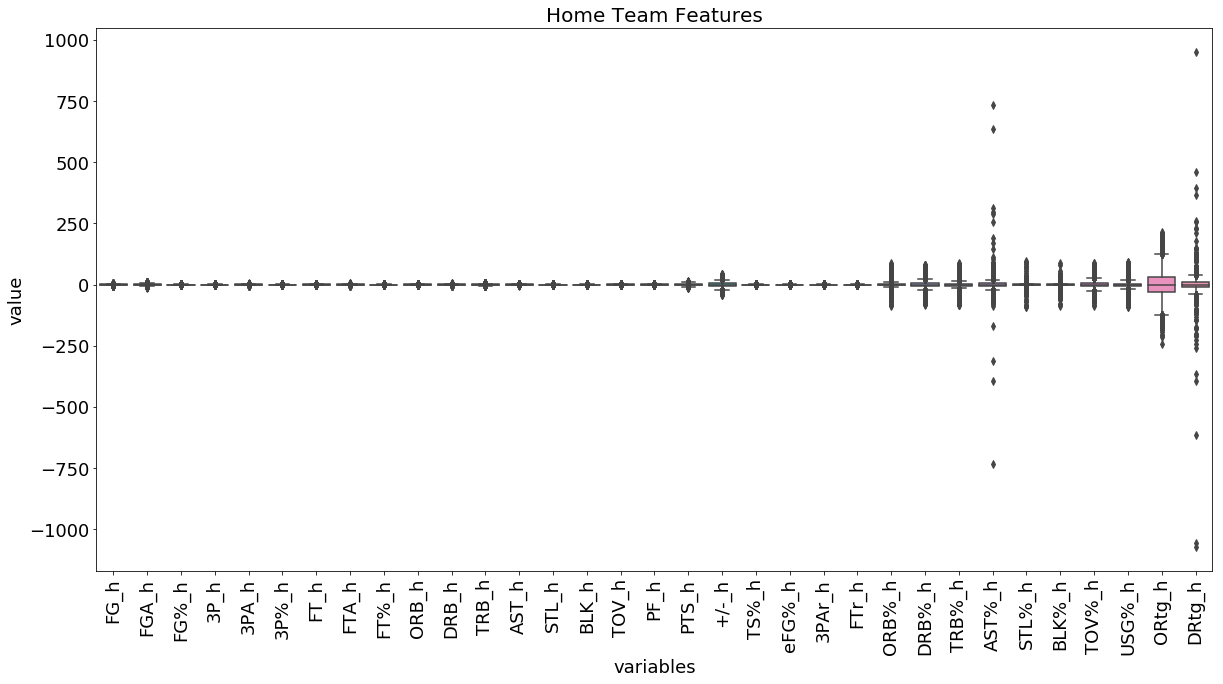

In [112]:
boxplot_features(home_df)

##### Away Team Features

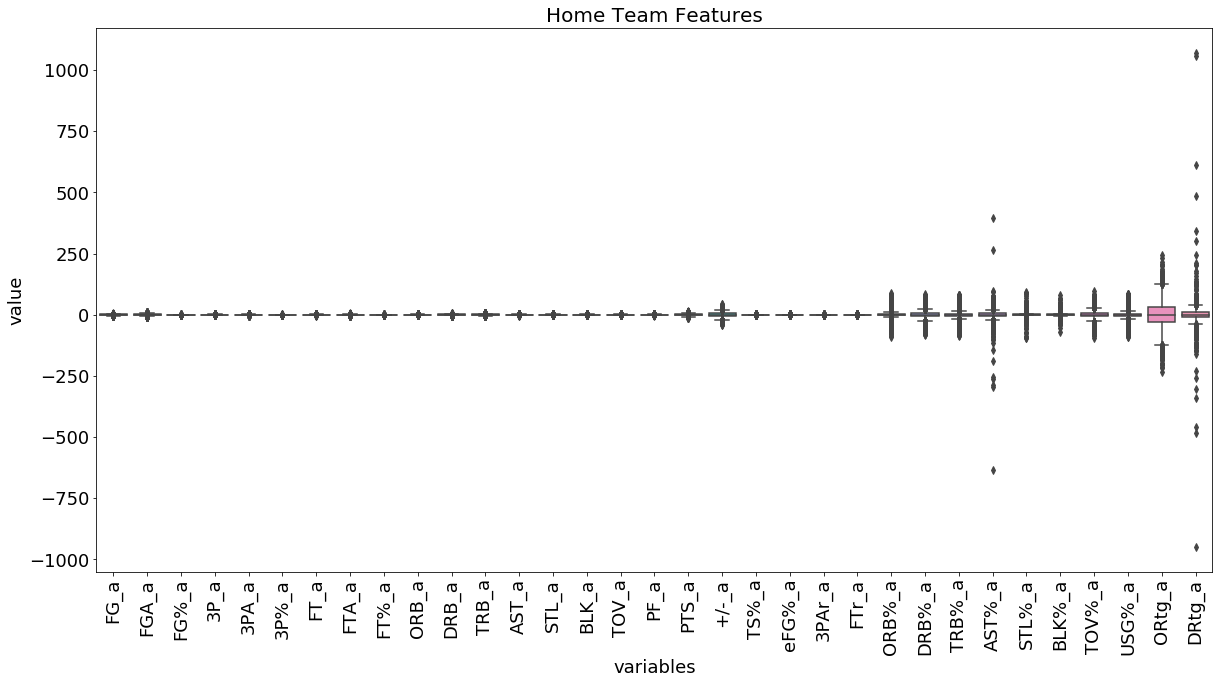

In [113]:
boxplot_features(away_df)

### EDA Part 1: Distribution of Features

#### Home Team Basic Statistics

In [116]:
# where are the home basic features?
home_colname_basic = home_colname[:19]
home_basic_df = clean_df_t1.loc[:, home_colname_basic]
home_basic_df.head(3)

,FG_h,FGA_h,FG%_h,3P_h,3PA_h,3P%_h,FT_h,FTA_h,FT%_h,ORB_h,DRB_h,TRB_h,AST_h,STL_h,BLK_h,TOV_h,PF_h,PTS_h,+/-_h
1211,0.645228,0.792402,0.080630,0.086097,-0.399348,0.163466,-0.548738,-0.584930,-0.112230,0.610409,-0.086349,0.524060,-0.391059,0.388937,0.219257,0.032941,0.298708,0.827815,8.923935
1212,-2.117701,-4.824676,-0.274895,-0.425487,-0.422551,-0.196546,-0.507883,0.461844,-0.291756,0.016429,-1.212735,-1.196306,-0.901748,-0.629611,0.032576,-0.544318,-1.578820,-5.168773,3.906356
1213,-0.329319,-0.692141,0.159542,-0.259508,0.134829,-0.148615,0.274163,0.302846,0.063819,0.860348,-0.809918,0.050430,-0.147628,0.141825,0.326963,-0.773978,-1.010362,-0.643984,18.073030


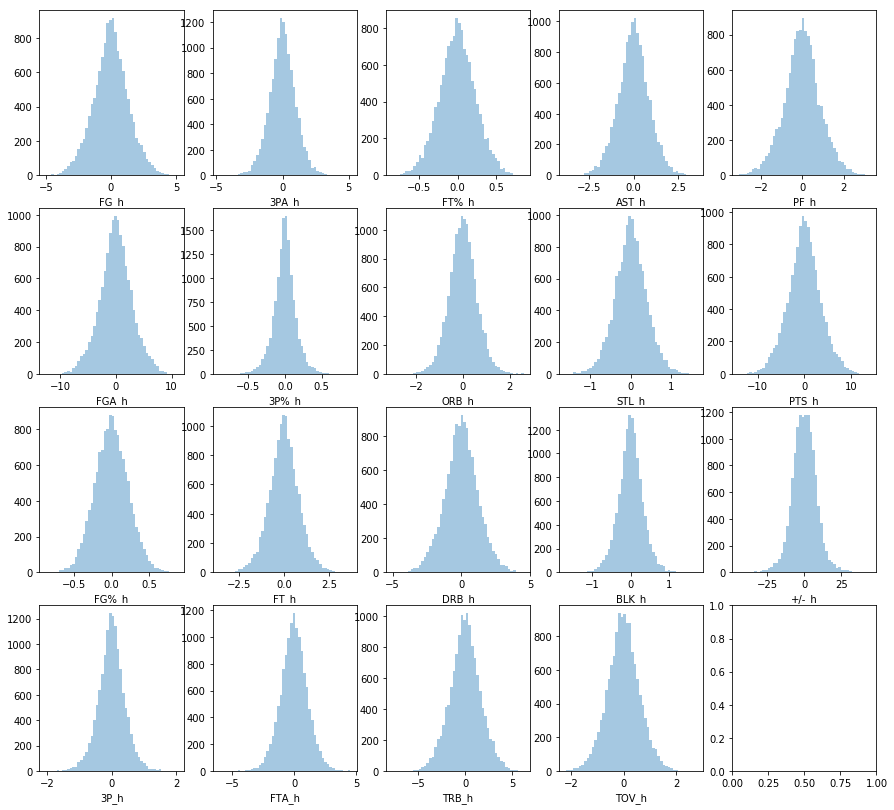

In [118]:
f, axes = plt.subplots(4, 5, figsize=(15, 14), sharex=False)
for i in range(19):
    sns.distplot(home_basic_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

#### Home Team Advanced Statistics

In [119]:
home_colname_ad = home_colname[19:33]
home_advanced_df = final_df_t1.loc[:, home_colname_ad]
home_advanced_df.head(3)

,TS%_h,eFG%_h,3PAr_h,FTr_h,ORB%_h,DRB%_h,TRB%_h,AST%_h,STL%_h,BLK%_h,TOV%_h,USG%_h,ORtg_h,DRtg_h
1211,0.029881,0.085915,-0.141853,-0.242283,4.619424,2.093098,2.204114,-8.076030,1.602857,2.395361,1.373305,-0.849849,32.673226,-14.320468
1212,-0.320025,-0.304089,0.017177,-0.084809,55.813133,-6.257992,29.970186,-6.783023,-1.583346,2.610503,-2.593215,13.248104,-35.676091,-8.194131
1213,0.174331,0.155030,0.103024,0.118598,26.148335,7.216073,16.575183,4.370002,3.495973,2.204012,-37.602033,14.855199,31.036221,-30.671251


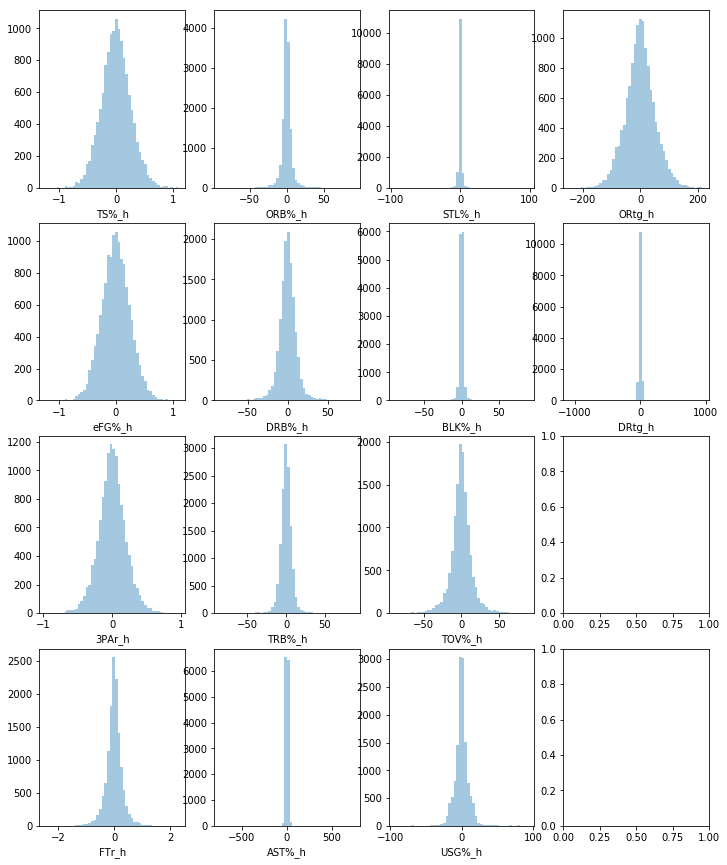

In [120]:
f, axes = plt.subplots(4, 4, figsize=(12, 15), sharex=False)
for i in range(14):
    sns.distplot(home_advanced_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

#### Away Team Basic Statistics

In [160]:
away_basic_df = final_df_t1.iloc[:, 40:59]
away_basic_df.head(3)

,FG_a,FGA_a,FG%_a,3P_a,3PA_a,3P%_a,FT_a,FTA_a,FT%_a,ORB_a,DRB_a,TRB_a,AST_a,STL_a,BLK_a,TOV_a,PF_a,PTS_a,+/-_a
1211,-0.171076,-0.225267,0.027630,-0.174374,-0.310400,-0.035396,0.065964,0.544759,-0.018244,0.305902,0.059450,0.365352,-0.152221,0.002734,-0.006356,-0.321251,-0.564609,-0.450562,2.330649
1212,1.103817,2.982445,0.035831,0.156339,0.487082,0.018893,0.938555,1.538525,0.277533,0.931260,1.201947,2.133208,0.205391,0.203685,0.121303,0.684417,0.540824,3.302528,-6.086140
1213,-2.334042,-4.118773,-0.366265,-0.399470,-1.187533,-0.123521,-1.037137,-1.450457,-0.245132,-0.468006,-1.774542,-2.242548,-1.207245,-0.288843,-0.157303,-0.813169,-0.998203,-6.104691,-1.442341


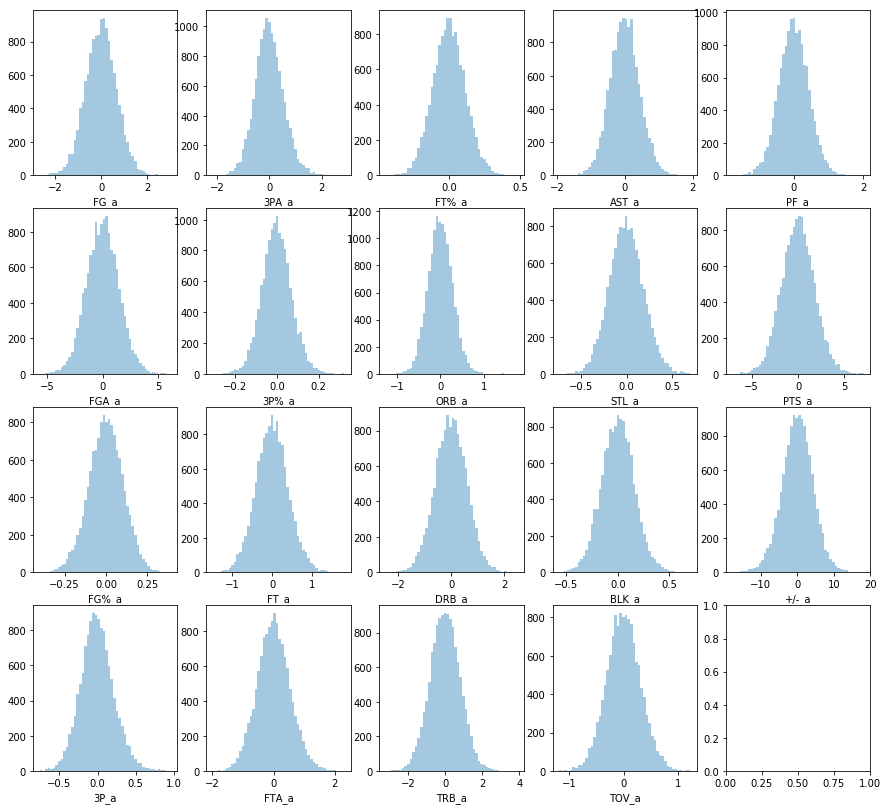

In [161]:
f, axes = plt.subplots(4, 5, figsize=(15, 14), sharex=False)
for i in range(19):
    sns.distplot(away_basic_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

#### Away Team Advanced Statistics

In [164]:
away_advanced_df = final_df_t1.iloc[:, 59:73]
away_advanced_df.head(3)

,TS%_a,eFG%_a,3PAr_a,FTr_a,ORB%_a,DRB%_a,TRB%_a,AST%_a,STL%_a,BLK%_a,TOV%_a,USG%_a,ORtg_a,DRtg_a
1211,0.018525,0.017302,-0.129241,-0.077940,12.895824,13.246887,13.169988,-0.152221,0.324190,-0.063566,-12.540609,11.686575,11.097291,-8.543862
1212,0.068164,0.038421,-0.019345,0.144521,5.258940,10.855521,7.635660,0.205391,0.533385,0.783108,2.486505,-1.452368,-24.019535,9.125712
1213,-0.387920,-0.394801,-0.109727,-0.138394,-0.181397,0.117316,-0.141606,-1.207245,-0.657913,-0.531121,-8.423801,-3.066554,-52.267773,1.113049


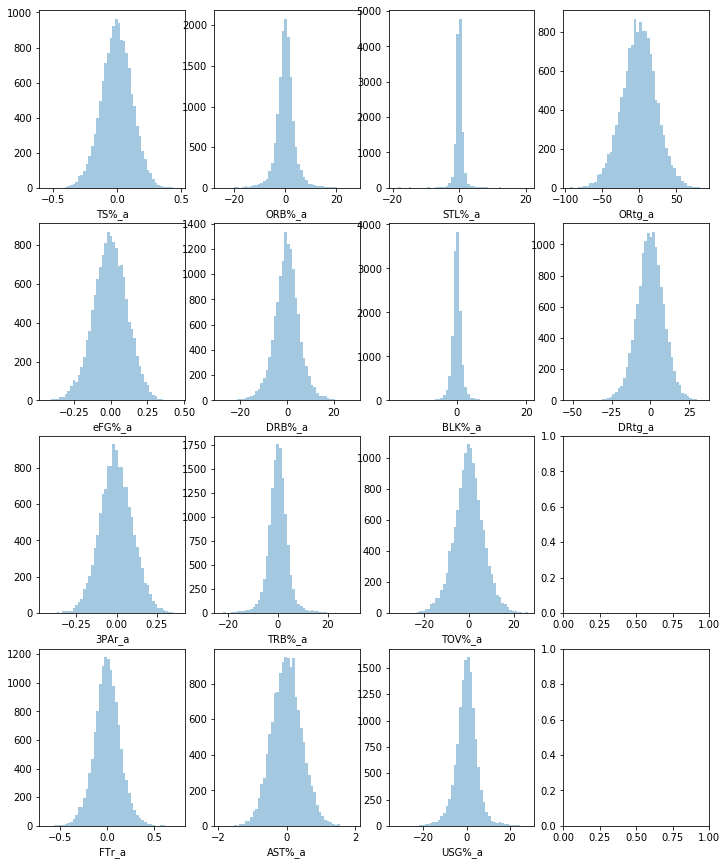

In [165]:
f, axes = plt.subplots(4, 4, figsize=(12, 15), sharex=False)
for i in range(14):
    sns.distplot(away_advanced_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

### EDA Part 2: Linear Correlation

#### Linearly Correlated Among Independent Variables

In [166]:
def corrheatmap(correlation):
    # add a mask to the upper right triangle
    heatmap_mask = np.zeros_like(correlation, dtype=np.bool)
    heatmap_mask[np.triu_indices_from(heatmap_mask)] = True

    # adjust the figure size
    f, ax = plt.subplots(figsize=(11, 9))

    # the color bar
    color_map = sns.diverging_palette(220, 10, as_cmap=True)
    # the main heatmap plot
    sns.heatmap(correlation, mask = heatmap_mask, cmap = color_map,
                square = True, linewidths = 3., center = 0,
                vmax = 1, vmin = -1, cbar_kws={"shrink": .7})

##### Home Features

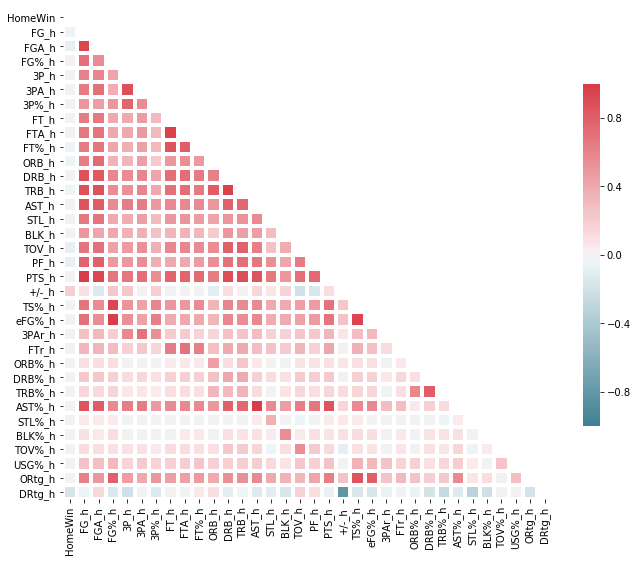

In [167]:
home_df = final_df_t1.iloc[:, [2]+list(range(5, 38))]
home_corr = home_df.corr()
corrheatmap(home_corr)

##### Away Features

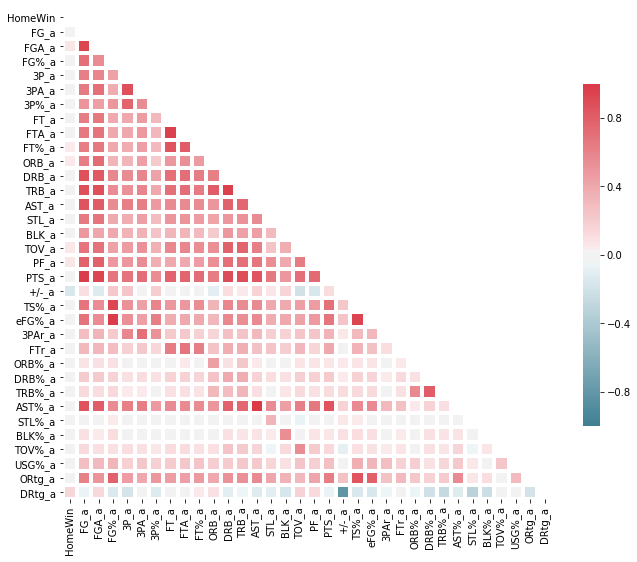

In [168]:
away_df = final_df_t1.iloc[:, [2]+list(range(40, final_df_t1.shape[1]))]
away_corr = away_df.corr()
corrheatmap(away_corr)

### EDA Part 3: Features Distribution vs. Target Variable Categories

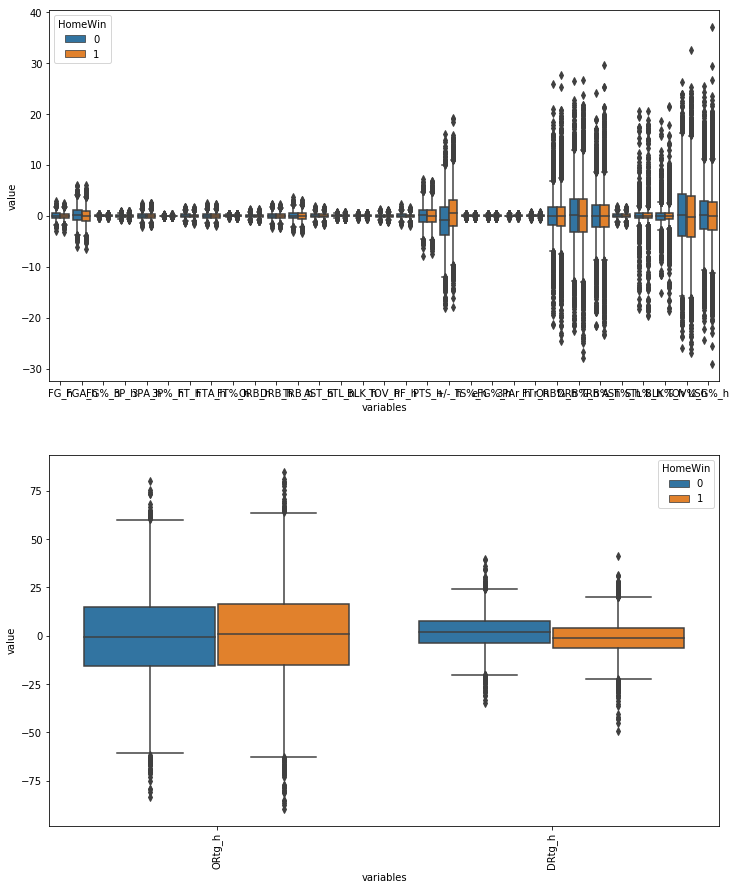

In [169]:
f, axes = plt.subplots(2, 1, figsize = (12, 15), sharex = False)
data_left = pd.melt(home_df.iloc[:, :-2], id_vars = "HomeWin", var_name="variables", value_name='value')
data_right = pd.melt(home_df.loc[:, ["HomeWin", "ORtg_h", "DRtg_h"]], id_vars = "HomeWin", var_name="variables", value_name='value')
for i in range(2):
    sns.boxplot(x = "variables", y = "value", hue = "HomeWin", data = [data_left, data_right][i], ax = axes[i])
    plt.xticks(rotation=90)

## Preprocessing

### Delete Redundant Dependent Variables

In [ ]:
analysis_table = final_df_t1.drop(["Date", "Game_Index", "Team_h", "Team_id_h", "Team_a", "Team_id_a"], axis = 1)

### train Test Split

Since we randomly split the whole dataset into two, the distribution of the target variable on the training set stays similar and is still unbalanced.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(analysis_table.drop("HomeWin", axis = 1), analysis_table["HomeWin"], test_size = 0.3, random_state = 101)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
sum(y_train == 1) / len(y_train)

### Min Max Scaler

I will scale my continuous features between 0 and 1 so that I will be able to do box-cox transformation with negative value later. The transformation will improve the computation of models which count the distance among data points. In a linear model, the feature with a larger value tends to be more important. Also, it will help speed up the gradient descent. 

In [ ]:
scaler = MinMaxScaler()
X_train.iloc[:,:] = scaler.fit_transform(X_train.values)
X_test.iloc[:,:] = scaler.transform(X_test.values)

### Box-cox Transformation

Conducting log transform may help to normalize a skewed distribution and to get a more robust result.

In [ ]:
X_train_scaled, fitted_lambda = stats.boxcox(X_train)
X_test_scaled = stats.boxcox(test, fitted_lambda)

### SMOTE: Oversampling

## Feature Selestion

Besides directly fitting all the features into the model, I will also do feature selection methods mentioned below. By doing so, we can solve the issues like:

- Curse of Dimensionality (Computation; Overfitting)

- Getting rid of redundant features

Method:

1. Feature Importance

    Based on the feature importance obtained from a decision tree, we can see what features are helpful when doing a categorical problem.


2. Filter Method: Information Gain or Mutual Information

    We will eliminate the independent variables which are not linearly related to the dependent variable. However, this method will neglect the non-linearly relationship.
    
    From the EDA above, we know most of the independent variables are not linearly correlated to the target variable. Therefore, I decided not to use linear correlation as the feature selection method here. Instead, I will try mutual information and 
3. Dimension Reduction

    PCA is a well-known dimention reduction technique. It tends to map the data points from the original dimension to a lower dimensional space and simultaneously, capture most of the variance among the data points. We will also try another method, LDA, which has some assumptions. The variance in each group should be similar and the samples are normally distributed. However sometimes, using a dimension reduction method will make the model hard to be interpretted.

[Feature Selection Reference](https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization#Feature-Selection-and-Random-Forest-Classification)

### Feature Importance

[Random Forests]("https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html")

In [ ]:
tuned_parameters = [{'n_estimatorsinteger': [], 'max_depth': [],
                     'max_features': [], 'random_state': [123]}]

clf = GridSearchCV(RandomForestClassifier(),
                   tuned_parameters, scoring = "roc_auc")

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)

### Filter Method

#### Drop High Correlated Features

#### Mutual information

In [ ]:
kepler_mutual_information = mutual_info_classif(kepler_X, kepler_y)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(kepler_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(kepler.columns[1:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)

#### Variance

In [ ]:
VarianceThreshold(.7).fit_transform(x_data_generated).shape

### Dimension Reduction

#### PCA

[PCA Packages]("https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html")

[Pipeline]("https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html")

#### LDA

[LDA Packages]("https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html")

## Model Implementation

- Cross Validation

    1. K Fold CV

    2. Grid Search or Random Search for Hyperparameter


- Model

    1. Logistic Regression (Our Baseline model)
    
    2. Ridge and Lasso Logistic Regression

    3. Random Forest (Bagging)

    4. KNN

    5. XGBoost (Boosting)

    6. SVM


- Metrics

    1. ROC

    2. Accuracy

    3. Recall Rate

    4. Precision

### Pipeline